In [33]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
from transformers import AutoTokenizer
import pandas as pd
import seaborn as sns
from datasets import Dataset
from os.path import join as oj
import pickle as pkl
import os
import dvu
dvu.set_style()
import analyze_utils

cols_output = ['final_answer_found',
               'final_model_queries', 'final_num_suffixes_checked']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load results

In [34]:
# dir_single_query = '/home/chansingh/mntv1/single_query_rough'
# dir_single_query = '/home/chansingh/mntv1/single_query_math_9_12'
dir_single_query = '/home/chansingh/mntv1/single_query_math_9_13'
r = analyze_utils.load_results_and_cache(dir_single_query, save_file='r.pkl')
r_single_query = pd.read_pickle(os.path.join(dir_single_query, 'r.pkl'))
r_single_query = analyze_utils.postprocess_results(r_single_query)


# dir_suffix_search = '/home/chansingh/mntv1/anli_rough' # note: anli_rought was missnamed
# dir_suffix_search = '/home/chansingh/mntv1/suffix_math_9_12' # note: anli_rought was missnamed
dir_suffix_search = '/home/chansingh/mntv1/suffix_math_9_13' # note: anli_rought was missnamed
r_suffix_search = analyze_utils.load_results_and_cache(dir_suffix_search, save_file='r.pkl')
r_suffix_search = pd.read_pickle(os.path.join(dir_suffix_search, 'r.pkl'))
r_suffix_search = analyze_utils.postprocess_results(r_suffix_search)

r = pd.concat((r_single_query, r_suffix_search)).sort_values('checkpoint')

 34%|███▎      | 148/441 [00:11<00:21, 13.36it/s]

skipping 571965a9ddc0d1705f0fa317ce777aeb873317dbf1ddd082dc4d85530ec9bf5bvzwp


100%|██████████| 441/441 [00:34<00:00, 12.97it/s]


Plot highly-summarized results

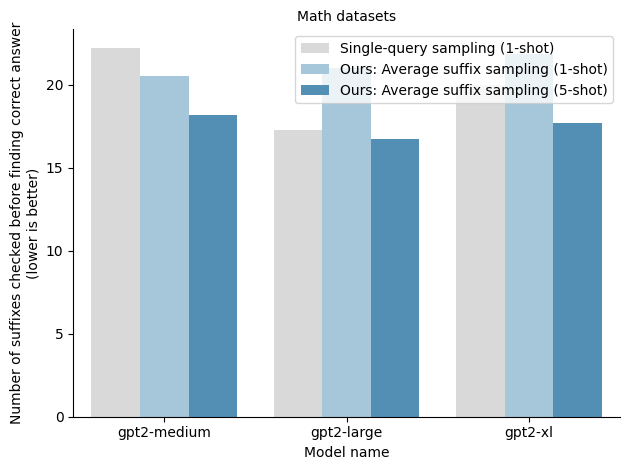

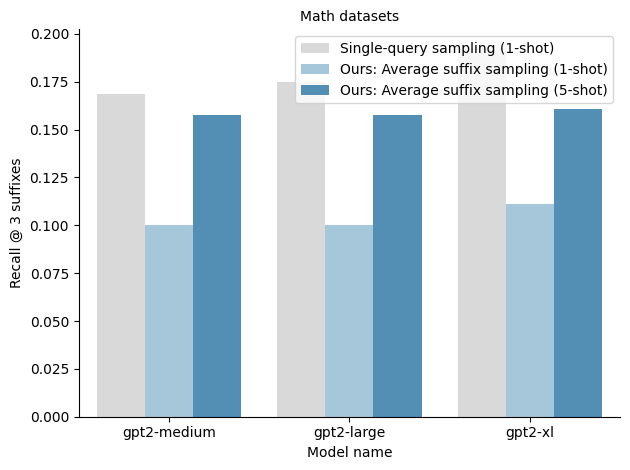

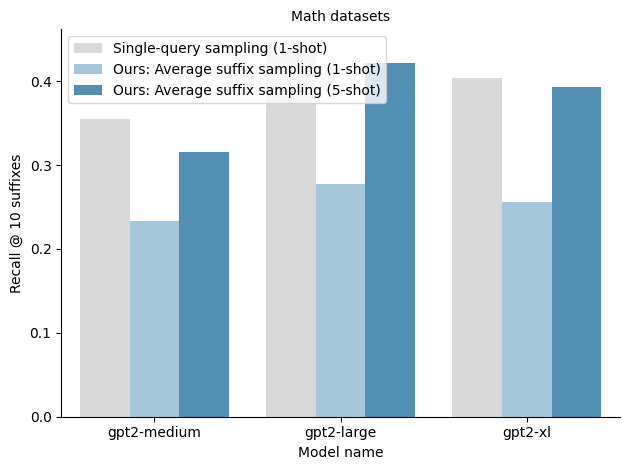

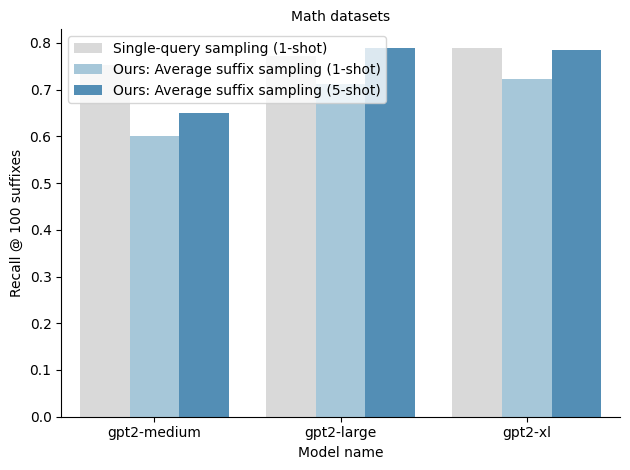

In [37]:
for metric_key in ['final_num_suffixes_checked',
                   f'Recall @ {3} suffixes',
                   f'Recall @ {10} suffixes', 
                   f'Recall @ {100} suffixes', ]:
    tab = analyze_utils.num_suffixes_checked_tab(r, metric_key=metric_key)
    analyze_utils.plot_tab(tab, metric_key=metric_key, title='Math datasets')


# look at some of the tables

In [16]:
# cols_to_view = r_single_query.columns # cols_to_view
cols_to_view = [col for col in r_single_query.columns if col.startswith('final')]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    rg = r.groupby(['checkpoint', 'n_shots', 'use_single_query', 'task_name'])[cols_to_view].mean().round(2)
    display(rg[rg['final_answer_found'] < 1.0])

In [10]:
r.groupby(['template_num_init_string', 'use_single_query']).median().round(2)['final_model_queries']

template_num_init_string  use_single_query
0                         0                   1.0
                          1                   1.0
1                         0                   2.0
                          1                   2.0
2                         0                   2.0
                          1                   2.0
Name: final_model_queries, dtype: float64

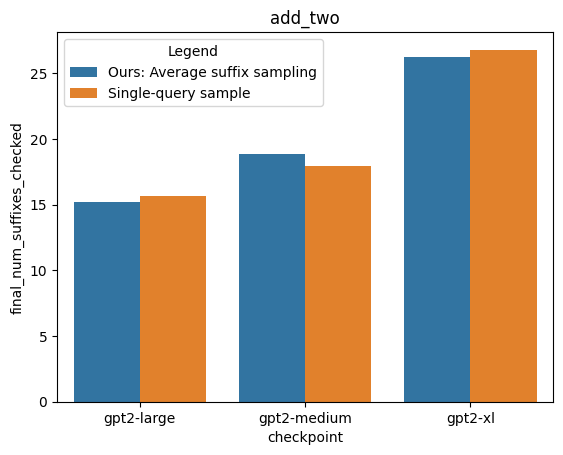

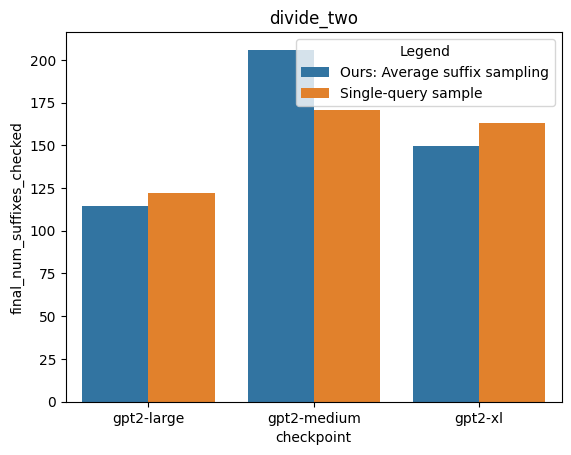

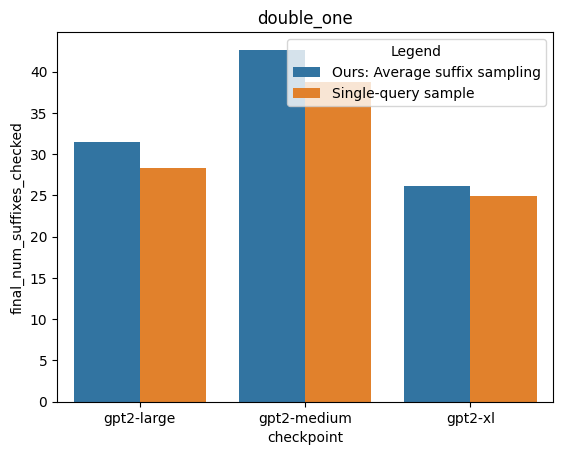

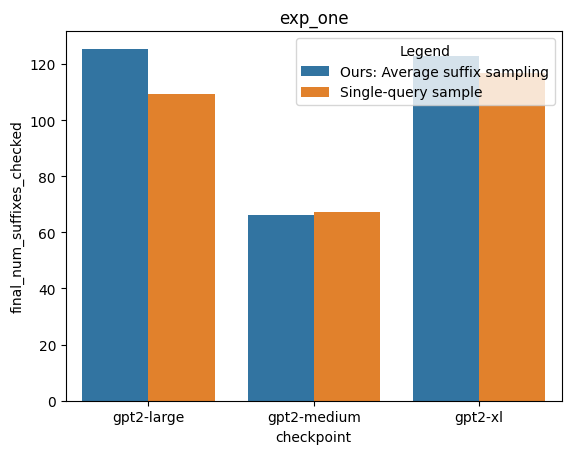

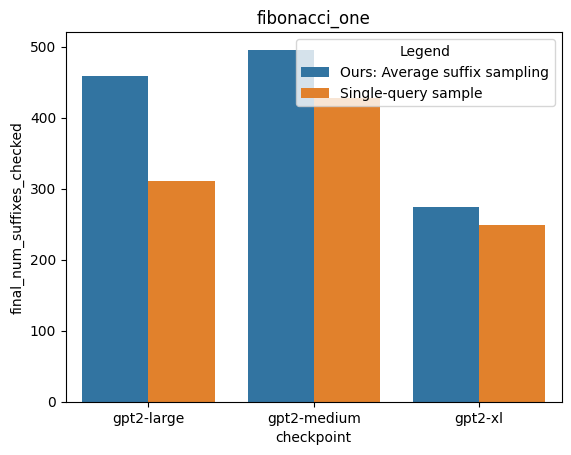

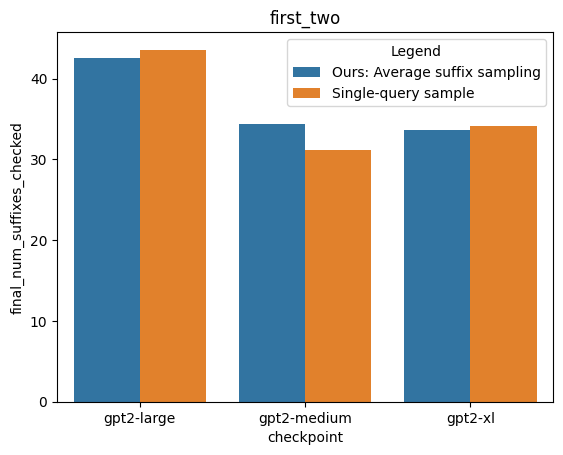

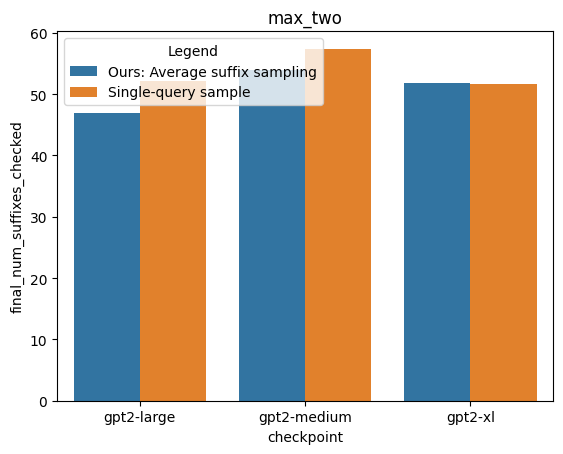

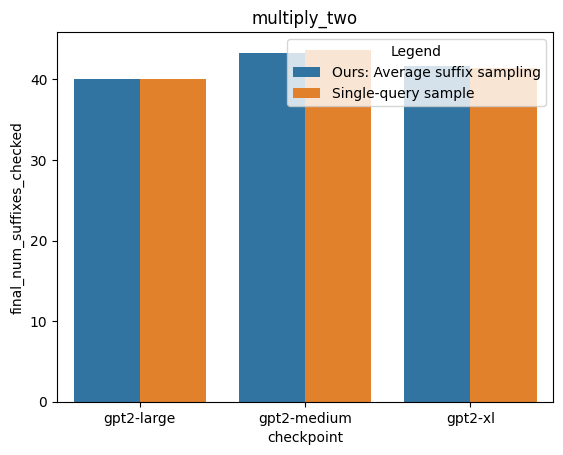

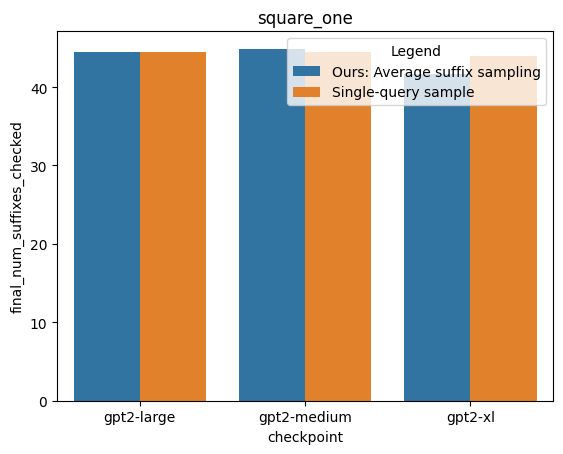

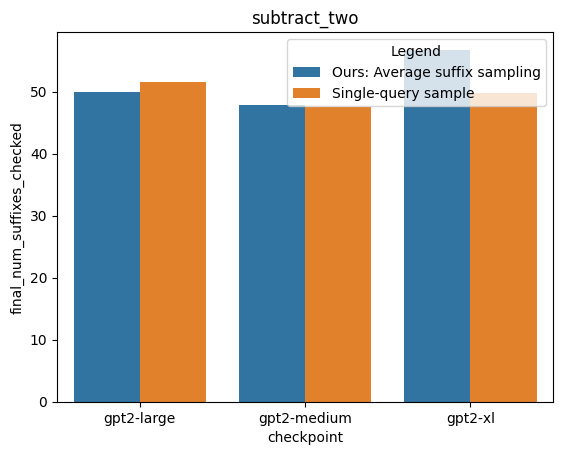

In [52]:
rp = rg.reset_index()
# display(rp)
rp['Legend'] = rp['use_single_query'].astype(bool).map(VALS)
rp = rp[rp['n_shots'] == 1]
for task_name in rp.task_name.unique():
    rpp = rp[rp.task_name == task_name]
    # display(rpp)
    plt.figure()
    plt.title(task_name)
    sns.barplot(x='checkpoint', y='final_num_suffixes_checked', hue='Legend', data=rpp) #data=tab[tab['n_shots'] == 1])

**break it down more**

In [8]:
r.groupby(['checkpoint', 'n_shots', 'single_query'])[
    cols_to_view].mean().round(2)  # mean over templates, task_name

final_model_queries  final_num_suffixes_checked  \
checkpoint  n_shots                                                    
gpt2-large  1                       2.35                       62.53   
            5                       2.49                       63.72   
            10                      1.35                       30.22   
gpt2-medium 1                       4.89                       90.95   
            5                       6.08                       85.98   
            10                      1.38                       33.12   
gpt2-xl     1                       2.60                       79.49   
            5                       3.17                       88.71   
            10                      1.51                       37.55   

                     final_answer_depth  final_answer_found  
checkpoint  n_shots                                          
gpt2-large  1                      1.64                0.92  
            5                      1.62                0.91  
            10                     1.35                1.00  
gpt2-medium 1                      1.69                0.99  
            5                      1.68                0.97  
            10                     1.36                1.00  
gpt2-xl     1                      1.63                1.00  
            5                      1.71                1.00  
            10                     1.42                1.00

In [9]:
rg = r_suffix_search.groupby(['checkpoint', 'n_shots', 'task_name'])
rg = rg[['final_model_queries','final_num_suffixes_checked']].mean().round(2) # mean over templates, task_name
print(rg.to_latex())

\begin{tabular}{lllrr}
\toprule
        &   &              &  final\_model\_queries &  final\_num\_suffixes\_checked \\
checkpoint & n\_shots & task\_name &                      &                             \\
\midrule
gpt2-large & 1 & add\_two &                 1.33 &                        5.67 \\
        &   & divide\_two &                 2.89 &                        8.67 \\
        &   & multiply\_two &                 3.89 &                       10.44 \\
gpt2-medium & 1 & add\_two &                 3.11 &                        8.44 \\
        &   & divide\_two &                 1.33 &                        5.44 \\
        &   & multiply\_two &                 1.33 &                        4.78 \\
gpt2-xl & 1 & add\_two &                 2.33 &                       12.11 \\
        &   & divide\_two &                 5.11 &                       18.78 \\
        &   & multiply\_two &                 1.33 &                        6.78 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_2765084/1313215481.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(rg.to_latex())
